In [1]:
!nvidia-smi

Tue Jun  8 01:25:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os, shutil
from glob import glob

In [3]:
from google.colab import drive
drive.mount('/content/grive')

Mounted at /content/grive


In [4]:
import cv2
from keras.preprocessing.image import ImageDataGenerator

# Feature Extraction

In [5]:
from tensorflow.keras.applications import VGG16

In [6]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

58892288/58889256 [==============================] - 0s 0us/step


In [7]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [8]:
image_gen = ImageDataGenerator(rescale=1./255)

In [9]:
train_dir = '/content/grive/MyDrive/smalldataset/train'
val_dir = '/content/grive/MyDrive/smalldataset/validation'
test_dir = '/content/grive/MyDrive/smalldataset/test'

In [10]:
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count,3))
    generator = image_gen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

In [11]:
train_features, train_labels = extract_features(train_dir, 2999)
validation_features, validation_labels = extract_features(val_dir, 1500)
test_features, test_labels = extract_features(test_dir, 1500)

Found 2999 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


In [12]:
train_features = np.reshape(train_features, (2999, 4*4*512))
validation_features = np.reshape(validation_features, (1500, 4*4*512))
test_features = np.reshape(test_features, (1500, 4*4*512))

# Building Model

In [13]:
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras import optimizers
from keras.callbacks import ModelCheckpoint


In [14]:
model = Sequential()

model.add(Dense(256, activation='relu', input_dim=(4*4*512)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [15]:
result = model.fit(train_features, train_labels,
                   epochs=30,
                   batch_size=20,
                   validation_data =(validation_features, validation_labels))

Epoch 1/30
150/150 [==============================] - 15s 7ms/step - loss: 0.4304 - accuracy: 0.8794 - val_loss: 0.1194 - val_accuracy: 0.9633
Epoch 2/30
150/150 [==============================] - 1s 5ms/step - loss: 0.0547 - accuracy: 0.9827 - val_loss: 0.0415 - val_accuracy: 0.9873
Epoch 3/30
150/150 [==============================] - 1s 4ms/step - loss: 0.0229 - accuracy: 0.9907 - val_loss: 0.0389 - val_accuracy: 0.9887
Epoch 4/30
150/150 [==============================] - 1s 4ms/step - loss: 0.0138 - accuracy: 0.9969 - val_loss: 0.0250 - val_accuracy: 0.9907
Epoch 5/30
150/150 [==============================] - 1s 4ms/step - loss: 0.0530 - accuracy: 0.9824 - val_loss: 0.0238 - val_accuracy: 0.9893
Epoch 6/30
150/150 [==============================] - 1s 4ms/step - loss: 0.0153 - accuracy: 0.9947 - val_loss: 0.0295 - val_accuracy: 0.9900
Epoch 7/30
150/150 [==============================] - 1s 4ms/step - loss: 0.0102 - accuracy: 0.9989 - val_loss: 0.0296 - val_accuracy: 0.9900
Epoch

In [16]:
model.save('model_small_1.h5')

# Evaluation on model

In [17]:
result.history['accuracy']

[0.9499832987785339,
 0.9839946627616882,
 0.9903301000595093,
 0.994331419467926,
 0.9896632432937622,
 0.994331419467926,
 0.9983327984809875,
 0.9966655373573303,
 0.9966655373573303,
 0.9953317642211914,
 0.9956651926040649,
 0.9986662268638611,
 0.9946649074554443,
 0.9966655373573303,
 0.9969990253448486,
 0.9903301000595093,
 0.9966655373573303,
 0.9983327984809875,
 0.9983327984809875,
 0.9966655373573303,
 0.9883294701576233,
 0.9939979910850525,
 0.9979993104934692,
 0.9993330836296082,
 0.9983327984809875,
 0.9983327984809875,
 0.9926642179489136,
 0.9973324537277222,
 0.9969990253448486,
 0.9976658821105957]

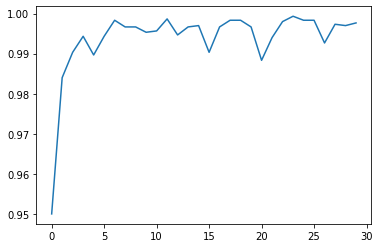

In [18]:
plt.plot(result.history['accuracy'])

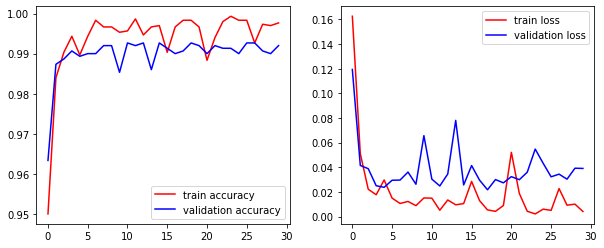

In [19]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)

plt.plot(result.history['accuracy'], label='train accuracy', color='red')
plt.plot(result.history['val_accuracy'], label='validation accuracy', color='blue')
plt.legend()

plt.subplot(1,2,2)
plt.plot(result.history['loss'], label='train loss', color='red')
plt.plot(result.history['val_loss'], label='validation loss', color='blue')
plt.legend()

plt.show()

In [36]:
# pred_probs = model.predict(test_features, verbose=0)
pred_classes = model.predict_classes(test_features, verbose=0)

from numpy import argmax
from keras.utils.np_utils import to_categorical
pred = argmax(to_categorical(pred_classes, 3 ), axis=1)
labels = argmax(test_labels,axis=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [70]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
confusion_matrix(labels, pred)

array([[500,   0,   0],
       [  2, 497,   1],
       [  2,   3, 495]])

In [72]:
print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       500
           1       0.99      0.99      0.99       500
           2       1.00      0.99      0.99       500

    accuracy                           0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500



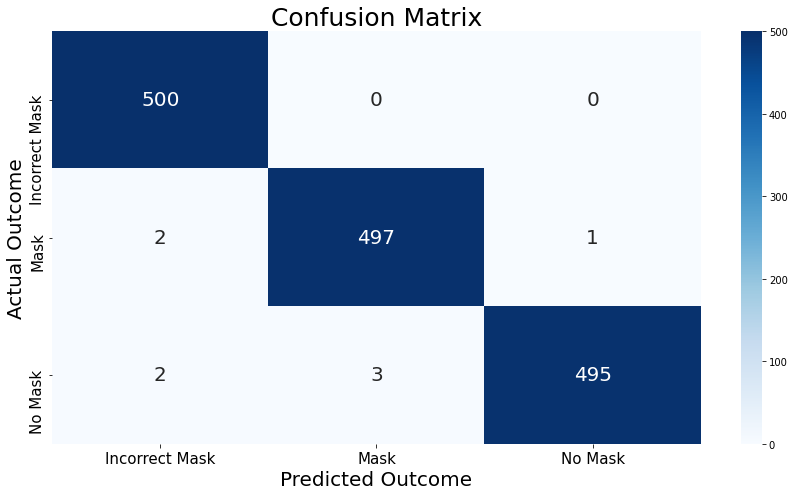

In [73]:
plt.figure(figsize=(35,7))
plt.subplot(131)
ax = sns.heatmap(confusion_matrix(labels, pred.round()),
            annot = True, annot_kws={"size":20}, fmt="d",cmap = "Blues")

plt.title('Confusion Matrix', size=25)
plt.xlabel('Predicted Outcome', size=20)
plt.ylabel('Actual Outcome', size=20)
labels = ['Incorrect Mask', 'Mask', 'No Mask']
ax.set_xticklabels(labels, size=15)
ax.set_yticklabels(labels, size=15)
plt.tight_layout()
plt.show();